In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sun Feb 03 2019 

CPython 3.6.8
IPython 7.2.0

numpy 1.13.3
scipy 0.19.1
sklearn 0.19.1
pandas 0.24.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.20.5-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.getenv('THESIS_ROOT')
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
REC_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'recplots'))
DIRECT_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'direct'))
GAF_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'gaf'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
# meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES).values

/home/kovar/thesis_project/
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/50a.fif...
This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16930 =      0.000 ...    67.720 secs
Ready.


<ipython-input-3-1e7cd7d477f5>:32: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))


In [4]:
# Welford's algorithm for computing running mean and variance
def update(existingAggregate, newValues):
    (count, mean, M2) = existingAggregate
    for newValue in newValues: 
        count += 1
        delta = newValue - mean
        mean += delta / count
        delta2 = newValue - mean
        M2 += delta * delta2
        existingAggregate = (count, mean, M2)

    return (count, mean, M2)

def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    (mean, variance) = (mean, M2/count) 
    if count < 2:
        return float('nan')
    else:
        return (mean, np.sqrt(variance))

In [5]:
# Algos
from scipy.spatial.distance import pdist, squareform
import math

def rec_plot(data):
    if len(data.shape) > 1:
        return squareform(pdist(data)).astype('float64')
    else:
        return squareform(pdist(data[:,None])).astype('float64')

def tabulate(x, y, f):
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(x, y):
    return math.cos(x+y)

def gaf(serie):
    # Min-Max scaling
    min_ = np.amin(serie)
    max_ = np.amax(serie)
    scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    # Polar encoding
    phi = np.arccos(scaled_serie)

    # GAF Computation (every term of the matrix)
    gaf = tabulate(phi, phi, cos_sum)

    return gaf

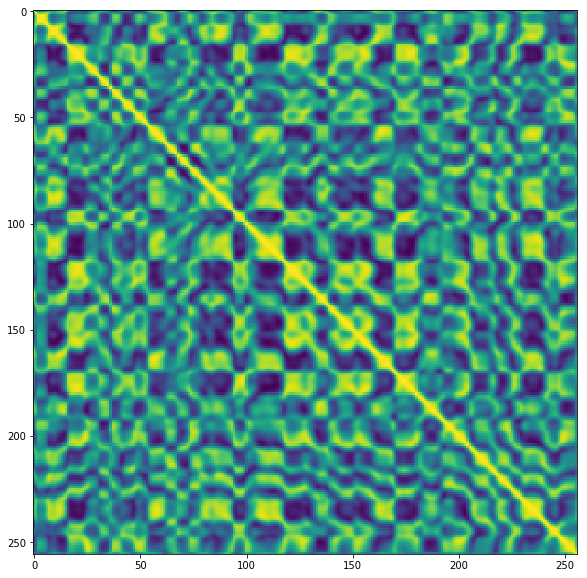

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(data):
    return cosine_similarity(data)

plt.figure(figsize=(10,10))
plt.imshow(cos_sim(data[:256,:]))
plt.show()

# Compute recurrence plot / GAF (multichannel distance)

In [56]:
count, mean, M2 = 0, 0, 0

def compute_vec(file, f, path, ww=256, maxl=np.infty):
    global count, mean, M2
    minl = ww
    start = 0
    chunk_num = 0
    # for fn in os.listdir(path):
    #     no_ext, _ = os.path.splitext(file.name)
    #     if fn.startswith(no_ext):
    #         print('Returning None, file ', no_ext, 'at teast partially processed')
    #         return None
    while start+ww <= min(maxl, len(file.df['FP1'].values)):
        # Add third dimension to make Keras happy
        r = np.zeros((ww, ww, 1))
        data = file.df.values
        # Here we may select only a subset of channels, let's try all for now
        r[:,:,0] = f(data[start:start+ww, :])
        if 2*len(data) < minl + ww or r.shape[0]*r.shape[1] != ww*ww:
            print('Returning None, for file ', file.name, ', time series too short: ', len(data))
            print('Or returned wrong shape: ', r.shape, start+ww)
            return None
        # count, mean, M2 = update((count, mean, M2), r.reshape(-1))
        np.save(
            os.path.join(path, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))), r, fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [57]:
import logging
mne.set_log_level(logging.ERROR)
count, mean, M2 = 0, 0, 0
for i, file in enumerate(files_builder(DataKind('processed'))):
    # compute_vec(file, rec_plot, os.path.join(REC_ROOT, 'vectors'))
    compute_vec(file, cos_sim, os.path.join(GAF_ROOT, 'cos_sim'))
    print('Processed: ', i)

Processed:  0
Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Proce

In [142]:
mean, st = finalize((count, mean, M2))
path = os.path.join(REC_ROOT, 'vectors')
for fn in os.listdir(path):
    filepath = os.path.join(path, fn)
    r = np.load(filepath)
    r = (r-mean) / std
    # assert (r >= -1).all() and (r <= 1).all()
    np.save(filepath, r, fix_imports=False)

# Compute recurrence plot / GAF (separate channels)

In [26]:
def compute_sep(file, f, path, ww=256, maxl=np.infty):
    minl = ww
    start = 0
    chunk_num = 0
    while start+ww <= min(maxl, len(file.df['FP1'].values)):
        for i, channel in enumerate(CHANNEL_NAMES):
            # file_found = False
            # for fn in os.listdir(os.path.join(path, channel)):
            #     no_ext, _ = os.path.splitext(file.name)
            #     if fn.startswith(no_ext):
            #         print('File ', fn, ' already processed, for channel ', channel, ', skipping...')
            #         file_found = True
            #         break
            # if file_found: continue
            data = file.df[channel].values
            r = f(data[start:start+ww])
            if 2*len(data) < minl + ww or r.shape[0]*r.shape[1] != ww*ww:
                print('Skipping, file ', file.name, ', time series too short: ', len(data))
                print('Or returned wrong shape: ', r.shape, start+ww)
                continue
            counts[i], means[i], M2s[i] = update((counts[i], means[i], M2s[i]), r.reshape(-1))
            np.save(
                os.path.join(path, channel, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))),
                r, fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [29]:
CHANNEL_NAMES = ['T6',]
counts, means, M2s = np.zeros(19), np.zeros(19), np.zeros(19)
final_means, final_stds = np.zeros(19), np.zeros(19)

for channel in CHANNEL_NAMES:
    if not os.path.exists(os.path.join(GAF_ROOT, 'sep_channels', channel)):
        os.makedirs(os.path.join(GAF_ROOT, 'sep_channels', channel))

import logging
mne.set_log_level(logging.ERROR)
for i, file in enumerate(files_builder(DataKind('processed'))):
    # compute_sep(file, rec_plot, os.path.join(REC_ROOT, 'sep_channels'))
    compute_sep(file, gaf, os.path.join(GAF_ROOT, 'sep_channels'))
    print('Processed: ', i)
    
print('Finalizing...')
for i in np.arange(len(CHANNEL_NAMES)):
    (final_means[i], final_stds[i]) = finalize((counts[i], means[i], M2s[i]))

Processed:  0
Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Proce

In [31]:
print('Saving...')
for i, channel in enumerate(CHANNEL_NAMES):
    path = os.path.join(GAF_ROOT, 'sep_channels', channel)
    for fn in os.listdir(path):
        filepath = os.path.join(path,fn)
        r = np.load(filepath)
        r[:, :] = (r[:, :]-final_means[i])/final_stds[i]
        np.save(filepath, r, fix_imports=False)

Saving...


In [113]:
print('Computing means and variances...')
path = os.path.join(DATA_ROOT, 'recplots_1')
for fn in os.listdir(path):
    r = np.load(os.path.join(path,fn))
    rs = r.reshape((-1, 19))
    for i in np.arange(r.shape[2]):
        counts[i], means[i], M2s[i] = update((counts[i], means[i], M2s[i]), rs[:, i])
        
print('Finalizing...')
for i in np.arange(len(CHANNEL_NAMES)):
    (final_means[i], final_stds[i]) = finalize((counts[i], means[i], M2s[i]))
    
print('Saving...')
for fn in os.listdir(path):
    filepath = os.path.join(path,fn)
    r = np.load(filepath)
    for i in np.arange(r.shape[2]):
        r[:, :, i] = (r[:, :, i]-final_means[i])/final_stds[i]
    np.save(filepath, r, fix_imports=False)

Computing means and variances...


FileNotFoundError: [Errno 2] No such file or directory: '/home/kovar/thesis_project/data/recplots_1/46a-48.npy'

# Directly to normalized images

In [10]:
def direct(data):
    return data

In [14]:
count, mean, M2 = 0, 0, 0

def compute_dir(file, f, path, ww=512, maxl=np.infty):
    global count, mean, M2
    minl = ww
    start = 0
    chunk_num = 0
    # for fn in os.listdir(path):
    #     no_ext, _ = os.path.splitext(file.name)
    #     if fn.startswith(no_ext):
    #         print('Returning None, file ', no_ext, 'at teast partially processed')
    #         return None
    while start+ww <= min(maxl, len(file.df['FP1'].values)):
        # Add third dimension to make Keras happy
        r = np.zeros((ww, len(CHANNEL_NAMES), 1))
        data = file.df.values
        # Here we may select only a subset of channels, let's try all for now
        r[:,:,0] = f(data[start:start+ww, :])
        if 2*len(data) < minl + ww or r.shape[0]*r.shape[1] != ww*len(CHANNEL_NAMES):
            print('Returning None, for file ', file.name, ', time series too short: ', len(data))
            print('Or returned wrong shape: ', r.shape, start+ww)
            return None
        count, mean, M2 = update((count, mean, M2), r.reshape(-1))
        np.save(
            os.path.join(path, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))), r, fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [15]:
count, mean, M2 = 0, 0, 0

import logging
mne.set_log_level(logging.ERROR)
for file in files_builder(DataKind('processed')):
    compute_dir(file, direct, os.path.join(DIRECT_ROOT))

In [16]:
mean, std = finalize((count, mean, M2))
path = os.path.join(DIRECT_ROOT)
for fn in os.listdir(path):
    filepath = os.path.join(path, fn)
    r = np.load(filepath)
    r = (r-mean) / std
    # assert (r >= -1).all() and (r <= 1).all()
    np.save(filepath, r, fix_imports=False)

# Models

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras import initializers

from keras import backend as K
K.set_floatx('float32')
K.floatx()

'float32'

## Traditional CNN models

In [18]:
# Best model so far
def define_model_1(dropout_rate=dropout_rate):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), input_shape=(image_height, image_width, num_channels), data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # model.add(Conv2D(4, (3, 3)))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [10]:
# VGG-like model
def define_model_2():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(image_height,image_width,num_channels)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='Adam',
                  # optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# Nikita's model
def define_model_3():
    model = Sequential()
    ki = initializers.RandomNormal(0, 0.1, 23)
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(image_height,image_width,num_channels),
                     kernel_initializer=ki))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=ki))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    # model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(lr=1e-4, beta_1=0.999, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
# From 'Classification of Recurrence Plots’ Distance Matrices with a Convolutional Neural Network for
# Activity Recognition' paper
def define_model_4():
    model = Sequential()
    ki = initializers.RandomNormal()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(image_height,image_width,num_channels),
                     kernel_initializer=ki))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=ki))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer=ki))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
# Temporary model with changes
def define_model_0(dropout_rate=dropout_rate):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), input_shape=(image_height, image_width, num_channels), data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # model.add(Conv2D(4, (3, 3)))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    opt = optimizers.SGD(lr=0.01,  decay=1e-6, momentum=0.9, nesterov=True)
    opt = optimizers.RMSprop()
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

## Specialized models

In [39]:
from keras.layers import Conv1D, Reshape, Flatten
def define_model_fc_w_conv():
    inp = Input((imsize, imsize))
    
    layer = concatenate(
        [Dense(1, activation='relu', input_shape=(i+1,))(Lambda(lambda x: x[:,i,:i+1])(inp))
         for i in np.arange(imsize)], axis=-1)
    layer = Reshape((imsize, 1), input_shape=(imsize,))(layer)
    
    layer = Dropout(0.25)((Conv1D(19, 8, activation='relu')(layer)))
    
    layer = Flatten()(layer)
    
    layer = Dropout(0.25)((Dense(128, activation='relu')(layer)))
     
    outp = Dense(2, activation='sigmoid')(layer)
    
    model = Model(inputs=inp, outputs=outp)
    
    opt = optimizers.RMSprop()
    opt = optimizers.SGD(lr=0.01,  decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

define_model_fc_w_conv().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 256, 256)     0                                            
__________________________________________________________________________________________________
lambda_6401 (Lambda)            (None, 1)            0           input_26[0][0]                   
__________________________________________________________________________________________________
lambda_6402 (Lambda)            (None, 2)            0           input_26[0][0]                   
__________________________________________________________________________________________________
lambda_6403 (Lambda)            (None, 3)            0           input_26[0][0]                   
__________________________________________________________________________________________________
lambda_640

In [14]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Concatenate, Lambda, Dropout, concatenate, BatchNormalization
from keras import optimizers, regularizers
from keras.utils import plot_model

imsize = 256
batch_size = 32
def define_model_fc():
    inp = Input((imsize, imsize))
    
    layer = concatenate(
        [Dense(1, activation='relu', input_shape=(i+1,))(Lambda(lambda x: x[:,i,:i+1])(inp))
         for i in np.arange(imsize)], axis=-1)
    
    layer = Dropout(0.25)((Dense(128, activation='relu')(layer)))
    
    # layer = Dropout(0.25)((Dense(32, activation='relu')(layer)))
     
    outp = Dense(2, activation='sigmoid')(layer)
    
    model = Model(inputs=inp, outputs=outp)
    
    opt = optimizers.RMSprop()
    opt = optimizers.SGD(lr=0.01,  decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

define_model_fc().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
lambda_1025 (Lambda)            (None, 1)            0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1026 (Lambda)            (None, 2)            0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1027 (Lambda)            (None, 3)            0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_102

In [47]:
import keras as k
import numpy as np
import tensorflow as tf

imsize = 256
def define_bd_shal_model(
    in_chans = 19,
    n_classes = 2,
    n_filters_time=40,
    n_filters_spat=40,
    filter_time_length=25,
    pool_time_length=75,
    pool_time_stride=15,
    final_conv_length=11,
    batch_norm=True,
    batch_norm_alpha=0.1,
    conv_nonlin=(lambda x: tf.math.square(x)),
    pool_mode='mean',
    pool_nonlin=(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, np.inf))), # Take safe log
    drop_prob=0.5,
):
    pool_class = dict(max=k.layers.MaxPooling2D, mean=k.layers.AveragePooling2D)[pool_mode]
    inp = k.layers.Input((in_chans, imsize, 1), name='input')
    
    layer = k.layers.Conv2D(
        filters=n_filters_time,
        kernel_size=(1, filter_time_length),
        use_bias=not batch_norm,
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        data_format='channels_last',
        input_shape=(imsize, imsize, 1),
        name='conv_time'
    )(inp)
    
    layer = k.layers.Conv2D(
        filters=n_filters_spat,
        kernel_size=(in_chans, 1),
        use_bias=not batch_norm,
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        name='conv_spat'
    )(layer)
    
    # Affine in orig - what it means? TODO: Apply here
    # Also, in orig some initialization
    if batch_norm:
        layer = k.layers.BatchNormalization(
            axis=-1,
            momentum=batch_norm_alpha,
            epsilon=1e-5,
            name='batch_norm',
            # There are other default params which may be diff. from orig.
        )(layer)
    
    layer = k.layers.Lambda(conv_nonlin, name='conv_nonlin')(layer)
    
    layer = pool_class(
        pool_size=(1, pool_time_length),
        strides=(1, pool_time_stride),
        name='pool'
    )(layer)
    
    layer = k.layers.Lambda(pool_nonlin, name='pool_nonlin')(layer)
    
    layer = k.layers.Dropout(drop_prob, name='drop')(layer)
    
    # TODO: Figure out final convolution length
    
    layer = k.layers.Conv2D(
        filters=n_classes,
        kernel_size=(1, final_conv_length),
        use_bias=True,
        activation='softmax',
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        name='conv_classifier'
    )(layer)
    
    layer = k.layers.Lambda(lambda x: x[:,0,0,:], name='squeeze')(layer)
    
    model = k.models.Model(inp, layer)
    model.compile(
        optimizer=k.optimizers.SGD(lr=0.01, momentum=0.99, decay=1e-5, nesterov=True),
        loss=k.losses.binary_crossentropy,
        metrics=['accuracy'],
        loss_weights=None,
        sample_weight_mode=None,
        weighted_metrics=None, 
        target_tensors=None
    )
    
    return model

define_bd_shal_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19, 256, 1)        0         
_________________________________________________________________
conv_time (Conv2D)           (None, 19, 232, 40)       1000      
_________________________________________________________________
conv_spat (Conv2D)           (None, 1, 232, 40)        30400     
_________________________________________________________________
batch_norm (BatchNormalizati (None, 1, 232, 40)        160       
_________________________________________________________________
conv_nonlin (Lambda)         (None, 1, 232, 40)        0         
_________________________________________________________________
pool (AveragePooling2D)      (None, 1, 11, 40)         0         
_________________________________________________________________
pool_nonlin (Lambda)         (None, 1, 11, 40)         0         
__________

In [8]:
import keras as k
import numpy as np
import tensorflow as tf

imsize = 256
def define_bd_deep_model(
        in_chans=19,
        n_classes=2,
        input_time_length=256,
        final_conv_length=1,
        n_filters_time=25,
        n_filters_spat=25,
        filter_time_length=10,
        pool_time_length=3,
        pool_time_stride=3,
        n_filters_2=50,
        filter_length_2=5,
        n_filters_3=100,
        filter_length_3=5,
        n_filters_4=200,
        filter_length_4=5,
        first_nonlin=k.activations.elu,
        first_pool_mode='max',
        first_pool_nonlin=(lambda x: x),
        later_nonlin=k.activations.elu,
        later_pool_mode='max',
        later_pool_nonlin=(lambda x: x),
        drop_prob=0.5,
        double_time_convs=False,
        split_first_layer=True,
        batch_norm=True,
        batch_norm_alpha=0.1,
        stride_before_pool=False,
):
    if stride_before_pool:
        conv_stride = pool_time_stride
        pool_stride = 1
    else:
        conv_stride = 1
        pool_stride = pool_time_stride
    # TODO: Behavior of their Avg differs
    pool_class_dict = dict(max=k.layers.MaxPool2D, mean=k.layers.AvgPool2D) # AvgPool2dWithConv)
    first_pool_class = pool_class_dict[first_pool_mode]
    later_pool_class = pool_class_dict[later_pool_mode]

    inp = k.layers.Input((in_chans, imsize, 1), name='input')
    
    layer = k.layers.Conv2D(
        filters=n_filters_time,
        kernel_size=(1, filter_time_length),
        use_bias=not batch_norm,
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        data_format='channels_last',
        input_shape=(imsize, imsize, 1),
        name='conv_time'
    )(inp)
    
    layer = k.layers.Conv2D(
        filters=n_filters_spat,
        kernel_size=(in_chans, 1),
        use_bias=not batch_norm,
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        name='conv_spat'
    )(layer)
    
    # Affine in orig - what it means? TODO: Apply here
    # Also, in orig some initialization
    if batch_norm:
        layer = k.layers.BatchNormalization(
            axis=-1,
            momentum=batch_norm_alpha,
            epsilon=1e-5,
            name='batch_norm',
            # There are other default params which may be diff. from orig.
        )(layer)
    
    layer = k.layers.Activation(first_nonlin, name='conv_nonlin')(layer)
    
    layer = first_pool_class(
        pool_size=(1, pool_time_length),
        strides=(1, pool_time_stride),
        name='pool'
    )(layer)
    
    layer = k.layers.Lambda(first_pool_nonlin, name='pool_nonlin')(layer)
    
    def add_conv_pool_block(layer, n_filters, filter_length, block_nr):
        suff = '_{:d}'.format(block_nr)
        layer = k.layers.Dropout(drop_prob, name='drop'+suff)(layer)

        layer = k.layers.Conv2D(
            filters=n_filters,
            kernel_size=(1, filter_length), # Not sure 
            strides=(1, conv_stride), # Not sure 
            use_bias=not batch_norm,
            kernel_initializer=k.initializers.glorot_uniform(),
            bias_initializer='zeros',
            name='conv'+suff
        )(layer)

        if batch_norm:
            layer = k.layers.BatchNormalization(
                axis=-1,
                momentum=batch_norm_alpha,
                epsilon=1e-5,
                name='batch_norm'+suff,
                # There are other default params which may be diff. from orig.
            )(layer)

        layer = k.layers.Activation(later_nonlin, name='nonlin'+suff)(layer)

        layer = later_pool_class(
            pool_size=(1, pool_time_length),
            strides=(1, pool_stride),
            name='pool'+suff
        )(layer)

        layer = k.layers.Lambda(later_pool_nonlin, name='pool_nonlin'+suff)(layer)

        return layer
    
    layer = add_conv_pool_block(layer, n_filters_2, filter_length_2, 2)
    layer = add_conv_pool_block(layer, n_filters_3, filter_length_3, 3)
    layer = add_conv_pool_block(layer, n_filters_4, filter_length_4, 4)
    
    layer = k.layers.Conv2D(
        filters=n_classes,
        kernel_size=(1, final_conv_length),
        use_bias=True,
        activation='softmax',
        kernel_initializer=k.initializers.glorot_uniform(),
        bias_initializer='zeros',
        name='conv_classifier'
    )(layer)
    
    layer = k.layers.Lambda(lambda x: x[:,0,0,:], name='squeeze')(layer)
    
    model = k.models.Model(inp, layer)
    model.compile(
        optimizer=k.optimizers.SGD(lr=0.01, momentum=0.99, decay=1e-5, nesterov=True),
        loss=k.losses.binary_crossentropy,
        metrics=['accuracy'],
        loss_weights=None,
        sample_weight_mode=None,
        weighted_metrics=None, 
        target_tensors=None
    )
    
    return model

model = define_bd_deep_model()

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='/home/kovar/deep_model.png', show_layer_names=True, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19, 256, 1)        0         
_________________________________________________________________
conv_time (Conv2D)           (None, 19, 247, 25)       250       
_________________________________________________________________
conv_spat (Conv2D)           (None, 1, 247, 25)        11875     
_________________________________________________________________
batch_norm (BatchNormalizati (None, 1, 247, 25)        100       
_________________________________________________________________
conv_nonlin (Activation)     (None, 1, 247, 25)        0         
_________________________________________________________________
pool (MaxPooling2D)          (None, 1, 82, 25)         0         
_________________________________________________________________
pool_nonlin (Lambda)         (None, 1, 82, 25)         0         
__________

# Prepare data

In [3]:
import numpy as np

def remove_middle(filenames, labels):
    ta = zip(filenames, labels)
    ta = np.array([(t, l) for t, l in ta], dtype=[('fname', 'S100'), ('label', 'int8')])
    ta = ta[:][(ta['label'] == -1) | (ta['label'] == 1)]
    ta['label'][ta['label'] == -1] = 0
    return ta['fname'].astype(str, copy=False), ta['label']

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical

fb = files_builder(DataKind('direct'), subfolder=())
seed = 123
fns = [fn[1] for fn in fb.file_names(include_path=True, subfolder=(), recursive=True)]
filenames, labels = remove_middle(fns, fb.get_labels(fns))
# labels = to_categorical(labels)
unique, counts = np.unique(labels, return_counts=True)
print('Overall samples: ', dict(zip(unique, counts)))
training_filenames, test_filenames, training_labels, test_labels = \
    train_test_split(filenames, labels, test_size=0.2, random_state=seed)
training_filenames, validation_filenames, training_labels, validation_labels = \
    train_test_split(training_filenames, training_labels, test_size=0.2, random_state=seed)
assert len(training_filenames) == len(training_labels)
assert len(validation_filenames) == len(validation_labels)
unique, counts = np.unique(training_labels, return_counts=True)
print('Training samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(test_labels, return_counts=True)
print('Testing samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('Validation samples: ', dict(zip(unique, counts)))
labels = to_categorical(labels, dtype=labels.dtype)
training_labels = to_categorical(training_labels, dtype=training_labels.dtype)
validation_labels = to_categorical(validation_labels, dtype=validation_labels.dtype)
test_labels = to_categorical(test_labels, dtype=test_labels.dtype)

Overall samples:  {0: 6801, 1: 6006}
Training samples:  {0: 4337, 1: 3859}
Testing samples:  {0: 1374, 1: 1188}
Validation samples:  {0: 1090, 1: 959}


# Train

In [5]:
from keras.utils import Sequence

ind = [False, False, False, False, False,
       False, False, False, False, False, 
       False, False, False, False, False, 
       True, False, False, False]

class batch_generator(Sequence):

    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.n = len(self.filenames)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
        # return len(self.filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        batch_y = self.labels[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        # assert len(batch_x) == batch_size, batch_x
        # assert len(batch_y) == batch_size, batch_y

        return np.array([
            np.load(file_name)[:,:, None] \
            # np.expand_dims(np.load(file_name), axis=-1) \
            # np.expand_dims(np.mean(np.load(file_name)[:, :, ind], axis=-1), axis=-1) \
            for file_name in batch_x]), batch_y

In [6]:
image_height, image_width = 256, 256
# image_height, image_width = 256, 19
num_channels = 1
batch_size = 128
num_epochs= 250
dropout_rate = 0.5

def plot_history(history):
    import matplotlib.pyplot as plt
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)

mchp_filepath = '/home/kovar/thesis_project/data/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model = define_bd_deep_model(in_chans=19)
mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
history = model.fit_generator(generator=training_batch_generator,
                                      steps_per_epoch=len(training_batch_generator),
                                      epochs=num_epochs,
                                      verbose=1,
                                      validation_data=validation_batch_generator,
                                      validation_steps=len(validation_batch_generator),
                                      callbacks=[
                                          mcp,
                                      #     # EarlyStopping(patience=4),
                                      #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                      #                       min_lr=0.001)
                                      ],
                                      use_multiprocessing=True,
                                      workers=8,
                                      max_queue_size=32)
plot_history(history)

Epoch 1/150
65/65 [==============================] - 11s 163ms/step - loss: 0.8565 - acc: 0.5112 - val_loss: 0.7010 - val_acc: 0.5530
Epoch 2/150
65/65 [==============================] - 9s 133ms/step - loss: 0.7526 - acc: 0.5234 - val_loss: 0.7164 - val_acc: 0.5388
Epoch 3/150
65/65 [==============================] - 9s 144ms/step - loss: 0.7283 - acc: 0.5340 - val_loss: 0.7149 - val_acc: 0.5578
Epoch 4/150
65/65 [==============================] - 9s 136ms/step - loss: 0.7025 - acc: 0.5375 - val_loss: 0.6982 - val_acc: 0.5520
Epoch 5/150
65/65 [==============================] - 9s 138ms/step - loss: 0.6979 - acc: 0.5457 - val_loss: 0.7140 - val_acc: 0.5564
Epoch 6/150
65/65 [==============================] - 9s 141ms/step - loss: 0.6909 - acc: 0.5477 - val_loss: 0.6830 - val_acc: 0.5554
Epoch 7/150
65/65 [==============================] - 9s 144ms/step - loss: 0.6989 - acc: 0.5431 - val_loss: 0.6929 - val_acc: 0.5481
Epoch 8/150
65/65 [==============================] - 9s 136ms/step -

65/65 [==============================] - 9s 143ms/step - loss: 0.4936 - acc: 0.7579 - val_loss: 0.5281 - val_acc: 0.7423
Epoch 63/150
65/65 [==============================] - 9s 138ms/step - loss: 0.4848 - acc: 0.7594 - val_loss: 0.5226 - val_acc: 0.7316
Epoch 64/150
65/65 [==============================] - 9s 143ms/step - loss: 0.4913 - acc: 0.7564 - val_loss: 0.6043 - val_acc: 0.6945
Epoch 65/150
65/65 [==============================] - 9s 143ms/step - loss: 0.4849 - acc: 0.7628 - val_loss: 0.5162 - val_acc: 0.7418
Epoch 66/150
65/65 [==============================] - 9s 134ms/step - loss: 0.4798 - acc: 0.7655 - val_loss: 0.5016 - val_acc: 0.7521
Epoch 67/150
65/65 [==============================] - 9s 142ms/step - loss: 0.4779 - acc: 0.7655 - val_loss: 0.5341 - val_acc: 0.7399
Epoch 68/150
65/65 [==============================] - 9s 143ms/step - loss: 0.4744 - acc: 0.7693 - val_loss: 0.5190 - val_acc: 0.7389
Epoch 69/150
65/65 [==============================] - 9s 140ms/step - loss:

65/65 [==============================] - 9s 143ms/step - loss: 0.3786 - acc: 0.8266 - val_loss: 0.4553 - val_acc: 0.7867
Epoch 124/150
65/65 [==============================] - 9s 141ms/step - loss: 0.3765 - acc: 0.8271 - val_loss: 0.4467 - val_acc: 0.7970
Epoch 125/150
65/65 [==============================] - 9s 146ms/step - loss: 0.3752 - acc: 0.8269 - val_loss: 0.4565 - val_acc: 0.7823
Epoch 126/150
65/65 [==============================] - 9s 138ms/step - loss: 0.3794 - acc: 0.8289 - val_loss: 0.4369 - val_acc: 0.8043
Epoch 127/150
65/65 [==============================] - 10s 147ms/step - loss: 0.3764 - acc: 0.8311 - val_loss: 0.4538 - val_acc: 0.7892
Epoch 128/150
65/65 [==============================] - 9s 144ms/step - loss: 0.3762 - acc: 0.8288 - val_loss: 0.5972 - val_acc: 0.7086
Epoch 129/150
65/65 [==============================] - 10s 146ms/step - loss: 0.3843 - acc: 0.8202 - val_loss: 0.4225 - val_acc: 0.8106
Epoch 130/150
65/65 [==============================] - 10s 152ms/st

In [16]:
from keras.models import load_model
model = load_model('/home/kovar/thesis_project/data/weights.145-0.41.hdf5')
test_batch_generator = batch_generator(test_filenames, test_labels, batch_size)
model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                         use_multiprocessing=False, verbose=0)

[0.43362006956855365, 0.80874316939890711]

## Evaluate with cross validation

In [1]:
import os
print(os.getenv('HDF5_USE_FILE_LOCKING'))

FALSE


In [ ]:
# For being able to use multiprocessing with generators and callbacks, use export HDF5_USE_FILE_LOCKING=FALSE
from sklearn.model_selection import StratifiedKFold
import numpy
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

seed = 123
numpy.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
fb = files_builder(DataKind('direct'), subfolder=())
fns = [fn[1] for fn in fb.file_names(include_path=True, subfolder=(), recursive=True)]
filenames, labels = remove_middle(fns, fb.get_labels(fns))
for i, (train, test) in enumerate(kfold.split(filenames, labels)):
    labels = to_categorical(labels)
    
    training_filenames, validation_filenames, training_labels, validation_labels = \
        train_test_split(filenames[train], labels[train], test_size=0.2, random_state=seed)
    
    training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
    validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)
    test_batch_generator = batch_generator(filenames[test], labels[test], batch_size)
    
    # mchp_filepath = '/home/kovar/thesis_project/data/models/weights_deep.{epoch:02d}-{val_loss:.2f}.hdf5'
    mchp_filepath = '/home/kovar/thesis_project/data/models/weights_deep_best.hdf5'
    model = define_bd_deep_model(in_chans=19)
    mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
    print('FOLD ', i+1)
    history = model.fit_generator(generator=training_batch_generator,
                                          steps_per_epoch=len(training_batch_generator),
                                          epochs=num_epochs,
                                          verbose=0,
                                          validation_data=validation_batch_generator,
                                          validation_steps=len(validation_batch_generator),
                                          callbacks=[
                                              mcp,
                                          #     # EarlyStopping(patience=4),
                                          #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                          #                       min_lr=0.001)
                                          ],
                                          use_multiprocessing=True,
                                          workers=8,
                                          max_queue_size=32)
    
    model = load_model(mchp_filepath)
    scores = model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                             use_multiprocessing=False, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Training fold  0


## Other

In [35]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    print('Total paramaters: {:,}'.format(trainable_count + non_trainable_count))
    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
get_model_memory_usage(128, define_model_1())

Total paramaters: 12,694.0


2.518